In [1]:
"""
This is for looking at evolving immuno-landscape as a function of time for individual COVID-19 patients.
"""
base_path = "../../../DataSets/2020_COVID19/"

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap
import umap.plot
import os
from pathlib import Path
import fcsparser
from matplotlib.pyplot import figure

In [2]:
file_name_pattern = "*.fcs"

fcs_file_paths = []
fcs_file_names = []
for filepath in Path(base_path).rglob(file_name_pattern):
    fcs_file_paths.append(filepath)
    fcs_file_names.append(filepath.name)

def split_file_name_into_parts(filename):
    """This function assumes the files are named as [accession patient sample date]."""
    spaces_positions = []
    for i,x in enumerate(filename):
        if x == ' ':
            spaces_positions.append(i)
            
    underscore_positions = []
    for i,x in enumerate(filename):
        if x == '_':
            underscore_positions.append(i)
    
    period_positions = []
    for i,x in enumerate(filename):
        if x == '.':
            period_positions.append(i)
    
    patient_start = spaces_positions[0] + 1
    sample_start = filename.find(" PB ") + 1
    date_start = sample_start + 3        
    tube_start = filename.find("_WB_") + 1
    if tube_start == 0:
        tube_start = filename.find("_PBMC_") + 1

    #default values
    accession = patient = sample = date = tube = "unknown"
    
    accession = filename[0:patient_start - 1]
    patient = filename[patient_start:sample_start - 1]
    sample = filename[sample_start:date_start]
    date = filename[date_start:tube_start-1]
    tube = filename[tube_start:period_positions[0]]
    
    if sample_start == 0: #then there was a troublesome case with no " PB " in the name.
        sample = "PB"  #All the cases in this study are peripheral blood.
        date_start = spaces_positions[1] + 1
        patient = filename[patient_start:date_start - 1]
        date = filename[date_start:tube_start-1]
    
    if accession == "unknown" or patient == "unknown" or sample == "unknown" or \
    date == "unknown" or tube == "unknown":
        print(filename)
        print([accession, patient, sample, date, tube])
    return [accession, patient, sample, date, tube]
        
parsed_file_names = []

for filename in fcs_file_names:
    parsed_file_names.append(split_file_name_into_parts(filename))
    
#print(parsed_folder_names)
df = pd.DataFrame(parsed_file_names)
df.columns = ['Accession', 'Patient', 'Sample', 'Date', 'Tube']
df['File_Path'] = fcs_file_paths
df['File_Name'] = fcs_file_names
#df['Date']= pd.to_datetime(df['Date']) 

print(df.shape)
df.head(5)    

(771, 7)


Accession          Patient Sample      Date            Tube  \
0   P20-197  TSANG_HANG_FONG    PB   05-22-20  WB_IgG_IgM_005   
1   P20-197  TSANG_HANG_FONG    PB   05-22-20   PBMC_MDSC_001   
2   P20-197  TSANG_HANG_FONG    PB   05-22-20       WB_T3_006   
3   P20-197  TSANG_HANG_FONG    PB   05-22-20   WB_NK KIR_007   
4   P20-197  TSANG_HANG_FONG    PB   05-22-20   WB_Memory_004   

                                           File_Path  \
0  ../../../DataSets/2020_COVID19/P20-197 TSANG_H...   
1  ../../../DataSets/2020_COVID19/P20-197 TSANG_H...   
2  ../../../DataSets/2020_COVID19/P20-197 TSANG_H...   
3  ../../../DataSets/2020_COVID19/P20-197 TSANG_H...   
4  ../../../DataSets/2020_COVID19/P20-197 TSANG_H...   

                                           File_Name  
0  P20-197 TSANG_HANG_FONG PB 05-22-20_WB_IgG_IgM...  
1  P20-197 TSANG_HANG_FONG PB 05-22-20_PBMC_MDSC_...  
2  P20-197 TSANG_HANG_FONG PB 05-22-20_WB_T3_006.fcs  
3  P20-197 TSANG_HANG_FONG PB 05-22-20_WB_NK KIR_...  
4  P20-197 TSANG_HANG_FONG PB 05-22-20_WB_Memory_...

In [3]:
print(len(df['Patient'].unique()))
print((df['Patient'].unique()))

print(len(df['Tube'].unique()))
print((df['Tube'].unique()))

78
['TSANG_HANG_FONG' 'GOLDENBERG_AGNES' 'SERRANO_FRANCIS' 'HICKS_RODNEY'
 'COVID_QC5_x2' 'SOTO_ANGEL_L' 'CARPIO_MEDARDO' 'BOYLES_TIM'
 'MANBER_DAVID' 'MYERS_ANDREW' 'SKURNIK_JOSHUA' 'COVID_QC7_x1' 'ALBA_SAM'
 'HAYS_MAURA' 'COVID_QC8_x2' 'WAI_XIAOQING' 'COVID_QC1_x2'
 'SEANGPEOAM_AEKKARIT' 'WACHT_JAMES' 'BEINSTEIN_LESLIE' 'COVID_QC8_x3'
 'CHEN_ZHEN' 'COVID_QC12' 'CRANE_JOYCE' 'ELLIS_PAULA' 'PALOMINO_LUZ'
 'NEUCALL_BONNIE' 'COVID_QC8_x1' 'HITSOUS_PETER_J' 'SEANGPEOAM_AEKARRIT'
 'GUEVARA_ MIELES_JORGE' 'SELBY_NADINE' 'FRAZIER_CLIFFORD' 'WANG_DONG'
 'VASILIOU_GEORGIOS' 'COVID_QC3_x2' 'LU_ZILI' 'VERA_WARNER_A'
 'COVID_QC4_x3' 'WHITE_LORI' 'DANDREA_DONATO' 'VILLA_MIOUEAS'
 'COVID_QC4_x2' 'COVID_QC1_x3' 'HAMER_DANIEL' 'COVID_QC7_x2'
 'VERDUGO_KRYSTYN' 'COVID_QC3_x3' 'LABADIA_JOSEPH' 'KATZ_EUGENE_H'
 'RYNECKI_NICOLE' 'COVID_QC4_x1' 'BRAYTON_PHILIP_S'
 'DIFUNTORUM_BERNADETTE' 'COVID_QC5_x3' 'COVID_QC6_x3' 'COVID_QC7_x3'
 'QC11_COVID' 'DUNKLEY_GIDEON' 'ISRAR_WAGMA' 'COVID_QC10' 'DARWISH_KAMAL'


In [4]:
df.to_excel(base_path + "parsed_file_names.xlsx", index = None)

In [5]:
#Now make a dataframe of the patient with the most samples.
patient_samples = df[df['Patient'].isin(df.Patient.mode().to_list())]
patient_samples = patient_samples.sort_values(by='Date')
patient_samples.head(1000)

Accession          Patient Sample      Date               Tube  \
118    P20-75  TSANG_HANG_FONG    PB   04-18-20      WB_Memory_004   
120    P20-75  TSANG_HANG_FONG    PB   04-18-20          WB_T3_006   
119    P20-75  TSANG_HANG_FONG    PB   04-18-20      PBMC_MDSC_001   
117    P20-75  TSANG_HANG_FONG    PB   04-18-20  WB_Checkpoint_003   
116    P20-75  TSANG_HANG_FONG    PB   04-18-20     WB_IgG_IgM_005   
115    P20-75  TSANG_HANG_FONG    PB   04-18-20      WB_NK KIR_007   
114    P20-75  TSANG_HANG_FONG    PB   04-18-20        WB_Treg_002   
754    P20-91  TSANG_HANG_FONG    PB   04-24-20      WB_Memory_004   
748    P20-91  TSANG_HANG_FONG    PB   04-24-20  WB_Checkpoint_003   
749    P20-91  TSANG_HANG_FONG    PB   04-24-20     WB_IgG_IgM_005   
750    P20-91  TSANG_HANG_FONG    PB   04-24-20          WB_T3_006   
751    P20-91  TSANG_HANG_FONG    PB   04-24-20        WB_Treg_002   
752    P20-91  TSANG_HANG_FONG    PB   04-24-20      WB_NK KIR_007   
753    P20-91  TSANG_HANG_FONG    PB   04-24-20      PBMC_MDSC_001   
605   P20-115  TSANG_HANG_FONG    PB   05-01-20        WB_Treg_002   
604   P20-115  TSANG_HANG_FONG    PB   05-01-20      WB_Memory_004   
603   P20-115  TSANG_HANG_FONG    PB   05-01-20      WB_NK KIR_007   
602   P20-115  TSANG_HANG_FONG    PB   05-01-20     WB_IgG_IgM_005   
601   P20-115  TSANG_HANG_FONG    PB   05-01-20  WB_Checkpoint_003   
600   P20-115  TSANG_HANG_FONG    PB   05-01-20          WB_T3_006   
606   P20-115  TSANG_HANG_FONG    PB   05-01-20      PBMC_MDSC_001   
354   P20-143  TSANG_HANG_FONG    PB   05-08-20     WB_IgG_IgM_005   
356   P20-143  TSANG_HANG_FONG    PB   05-08-20        WB_Treg_002   
355   P20-143  TSANG_HANG_FONG    PB   05-08-20      WB_Memory_004   
353   P20-143  TSANG_HANG_FONG    PB   05-08-20      PBMC_MDSC_001   
351   P20-143  TSANG_HANG_FONG    PB   05-08-20  WB_Checkpoint_003   
350   P20-143  TSANG_HANG_FONG    PB   05-08-20          WB_T3_006   
352   P20-143  TSANG_HANG_FONG    PB   05-08-20      WB_NK KIR_007   
658   P20-186  TSANG_HANG_FONG    PB   05-15-20        WB_Treg_002   
657   P20-186  TSANG_HANG_FONG    PB   05-15-20      PBMC_MDSC_001   
656   P20-186  TSANG_HANG_FONG    PB   05-15-20     WB_IgG_IgM_005   
655   P20-186  TSANG_HANG_FONG    PB   05-15-20      WB_NK KIR_007   
654   P20-186  TSANG_HANG_FONG    PB   05-15-20      WB_Memory_004   
652   P20-186  TSANG_HANG_FONG    PB   05-15-20  WB_Checkpoint_003   
653   P20-186  TSANG_HANG_FONG    PB   05-15-20          WB_T3_006   
5     P20-197  TSANG_HANG_FONG    PB   05-22-20        WB_Treg_002   
4     P20-197  TSANG_HANG_FONG    PB   05-22-20      WB_Memory_004   
3     P20-197  TSANG_HANG_FONG    PB   05-22-20      WB_NK KIR_007   
2     P20-197  TSANG_HANG_FONG    PB   05-22-20          WB_T3_006   
1     P20-197  TSANG_HANG_FONG    PB   05-22-20      PBMC_MDSC_001   
6     P20-197  TSANG_HANG_FONG    PB   05-22-20  WB_Checkpoint_003   
0     P20-197  TSANG_HANG_FONG    PB   05-22-20     WB_IgG_IgM_005   
159   P20-210  TSANG_HANG_FONG    PB   05-29-20      PBMC_MDSC_001   
160   P20-210  TSANG_HANG_FONG    PB   05-29-20      WB_Memory_004   
161   P20-210  TSANG_HANG_FONG    PB   05-29-20        WB_Treg_002   
162   P20-210  TSANG_HANG_FONG    PB   05-29-20     WB_IgG_IgM_005   
163   P20-210  TSANG_HANG_FONG    PB   05-29-20          WB_T3_006   
164   P20-210  TSANG_HANG_FONG    PB   05-29-20  WB_Checkpoint_003   
165   P20-210  TSANG_HANG_FONG    PB   05-29-20      WB_NK KIR_007   

                                             File_Path  \
118  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
120  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
119  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
117  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
116  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
115  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
114  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
754  ../../../DataSets/2020_COVID19/P20

In [6]:
tube_types = patient_samples['Tube'].unique()
print(tube_types)

['WB_Memory_004' 'WB_T3_006' 'PBMC_MDSC_001' 'WB_Checkpoint_003'
 'WB_IgG_IgM_005' 'WB_NK KIR_007' 'WB_Treg_002']


In [7]:
#Okay, I am now going to restrict it to the Treg tube and do the consecutive UMAPs.

patient_Treg_samples = patient_samples[patient_samples['Tube'] == tube_types[0]]
patient_Treg_samples = patient_Treg_samples.sort_values(by='Date')
patient_Treg_samples.head(10)

Accession          Patient Sample      Date           Tube  \
118    P20-75  TSANG_HANG_FONG    PB   04-18-20  WB_Memory_004   
754    P20-91  TSANG_HANG_FONG    PB   04-24-20  WB_Memory_004   
604   P20-115  TSANG_HANG_FONG    PB   05-01-20  WB_Memory_004   
355   P20-143  TSANG_HANG_FONG    PB   05-08-20  WB_Memory_004   
654   P20-186  TSANG_HANG_FONG    PB   05-15-20  WB_Memory_004   
4     P20-197  TSANG_HANG_FONG    PB   05-22-20  WB_Memory_004   
160   P20-210  TSANG_HANG_FONG    PB   05-29-20  WB_Memory_004   

                                             File_Path  \
118  ../../../DataSets/2020_COVID19/P20-75 TSANG_HA...   
754  ../../../DataSets/2020_COVID19/P20-91 TSANG_HA...   
604  ../../../DataSets/2020_COVID19/P20-115 TSANG_H...   
355  ../../../DataSets/2020_COVID19/P20-143 TSANG_H...   
654  ../../../DataSets/2020_COVID19/P20-186 TSANG_H...   
4    ../../../DataSets/2020_COVID19/P20-197 TSANG_H...   
160  ../../../DataSets/2020_COVID19/P20-210 TSANG_H...   

                                             File_Name  
118  P20-75 TSANG_HANG_FONG PB 04-18-20_WB_Memory_0...  
754  P20-91 TSANG_HANG_FONG PB 04-24-20_WB_Memory_0...  
604  P20-115 TSANG_HANG_FONG PB 05-01-20_WB_Memory_...  
355  P20-143 TSANG_HANG_FONG PB 05-08-20_WB_Memory_...  
654  P20-186 TSANG_HANG_FONG PB 05-15-20_WB_Memory_...  
4    P20-197 TSANG_HANG_FONG PB 05-22-20_WB_Memory_...  
160  P20-210 TSANG_HANG_FONG PB 05-29-20_WB_Memory_...

In [8]:
path = patient_Treg_samples['File_Path'].to_list()[0]
meta, data = fcsparser.parse(path, reformat_meta=True)
meta['_channels_']

del data['Time']
del data['FSC-H']
del data['SSC-H']
print(data.shape)
data.head()

(567657, 12)


FSC-A         SSC-A      FITC-A        PE-A  PerCP-Cy5-5-A  \
0  158846.640625   5074.590332  404.430023  234.240005   17081.220703   
1  121314.718750   7329.150391  448.350006  400.770020   16383.990234   
2  210750.359375  13692.060547  949.770020  662.460022   22446.781250   
3   88946.039062   3724.050049  252.540009  254.370010    8344.799805   
4  146326.140625   5272.229980  349.529999  272.670013   11534.490234   

      PE-Cy7-A   APC-A  APC-R700-A  APC-H7-A  Pacific Blue-A       V500C-A  \
0  3850.320068  1822.5      1036.5    1095.0     6646.319824   2763.179932   
1  4860.479980  1692.0      1015.5    1029.0    10974.689453   7448.040039   
2  5934.689941  3148.5      1357.5    1284.0    15263.279297  14316.209961   
3  2620.560059  1206.0       400.5     559.5     5336.640137   3197.699951   
4  3460.530029  1278.0       646.5     567.0     9713.969727   5223.419922   

       BV605-A  
0   416.160004  
1  1124.549927  
2  2405.159912  
3   465.119995  
4   856.799988

In [9]:
#subdata = data.values[0:200000, :]
subdata = data.values
def transform_FCS_data(fcs_data_values):
    new_values = fcs_data_values
    new_values[new_values < 1] = 1
    new_values = np.log10(new_values)
    return new_values

subdata = transform_FCS_data(subdata)

In [10]:
fit = umap.UMAP()
%time u = fit.fit(subdata)

CPU times: user 1h 3min 14s, sys: 45.4 s, total: 1h 4min
Wall time: 9min 3s


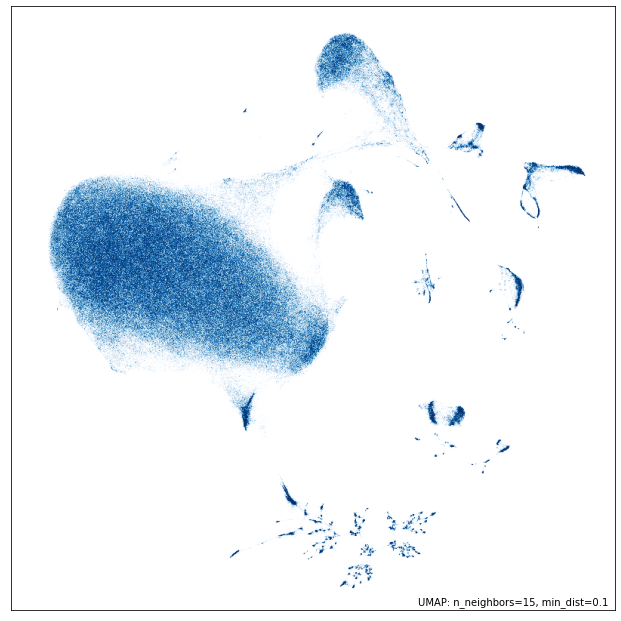

In [11]:
import umap.plot
umap.plot.points(u)

CPU times: user 38.9 ms, sys: 3.98 ms, total: 42.9 ms
Wall time: 41.8 ms


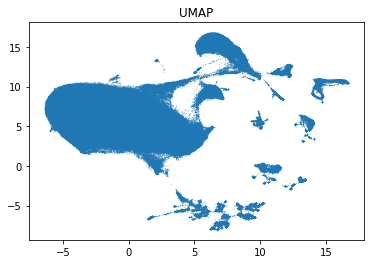

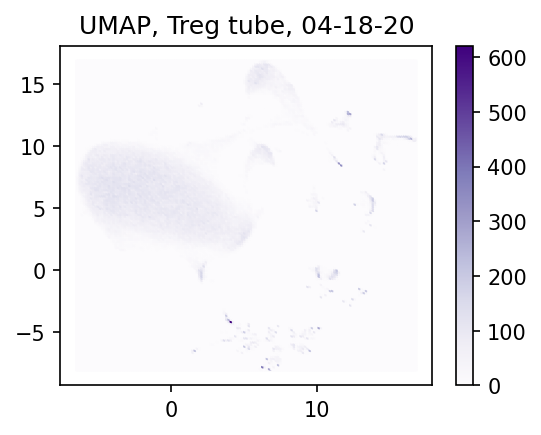

In [12]:
%time u = fit.transform(subdata)
plt.scatter(u[:,0], u[:,1], s=0.01)
plt.title('UMAP');
plt.show()

from matplotlib.pyplot import figure
figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')

#Plot it as a hexbin heatmap.
plt.hexbin(u[:,0], u[:,1], gridsize=(150,150), cmap=plt.cm.Purples)
plt.colorbar()
plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[0])
plt.show()


CPU times: user 5min 12s, sys: 596 ms, total: 5min 12s
Wall time: 1min


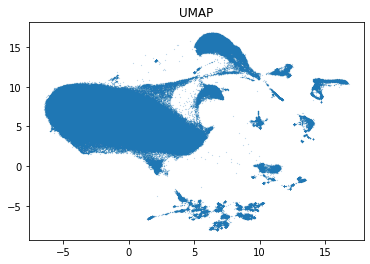

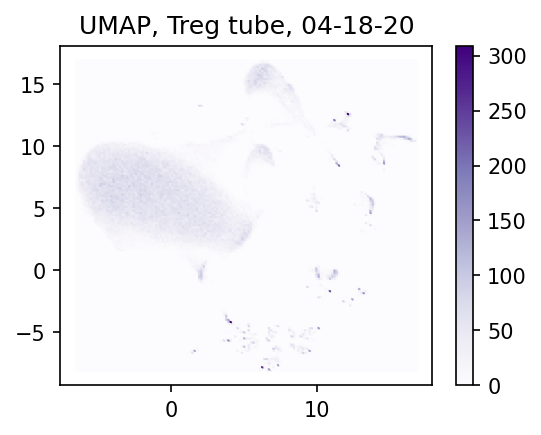

In [13]:
#Now demonstrate the use of the embedding on a different set of data from the same specimen.

subdata = transform_FCS_data(data.values[200000:, :])
%time u = fit.transform(subdata)

plt.scatter(u[:,0], u[:,1], s=0.01)
plt.title('UMAP');
plt.show()

from matplotlib.pyplot import figure
figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')

#Plot it as a hexbin heatmap.
plt.hexbin(u[:,0], u[:,1], gridsize=(150,150), cmap=plt.cm.Purples)
plt.colorbar()
plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[0])
plt.show()


(567657, 12)
CPU times: user 27min 19s, sys: 22 s, total: 27min 41s
Wall time: 2min 41s
CPU times: user 17.8 ms, sys: 0 ns, total: 17.8 ms
Wall time: 17.9 ms


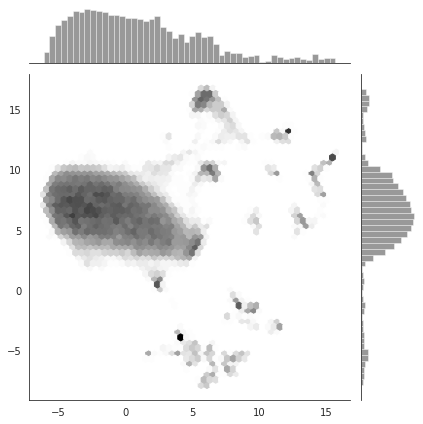

In [14]:
#Okay, now I am going to make the embedding using all points in the data.  
#Then, I will transform the other files and plot.

path = patient_Treg_samples['File_Path'].to_list()[0]
meta, data = fcsparser.parse(path, reformat_meta=True)
del data['Time']
del data['FSC-H']
del data['SSC-H']
print(data.shape)

data = transform_FCS_data(data.values[0:250000,:])

fit = umap.UMAP()
%time u = fit.fit(data)

#umap.plot.points(u)
#plt.show()

%time u = fit.transform(data)

"""
#Make a scatter plot.
figure(num=None, figsize=(6, 4.5), dpi=300, facecolor='w', edgecolor='k')
plt.scatter(u[:,0], u[:,1], s=0.005)
plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[0])
plt.show()

#Plot it as a hexbin heatmap.
figure(num=None, figsize=(6, 4.5), dpi=300, facecolor='w', edgecolor='k')
plt.hexbin(u[:,0], u[:,1], gridsize=(100,100))#, cmap=plt.cm.Reds)
plt.colorbar()
plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[0])
plt.show()


#
figure(num=None, figsize=(6, 4.5), dpi=300, facecolor='w', edgecolor='k')
plt.hist2d(u[:,0], u[:,1],bins=100)
plt.show()
"""
#
with sns.axes_style("white"):
    sns.jointplot(u[:,0], u[:,1], kind="hex", color="k", bins=100);
  

CPU times: user 6min 38s, sys: 1.12 s, total: 6min 40s
Wall time: 1min 1s


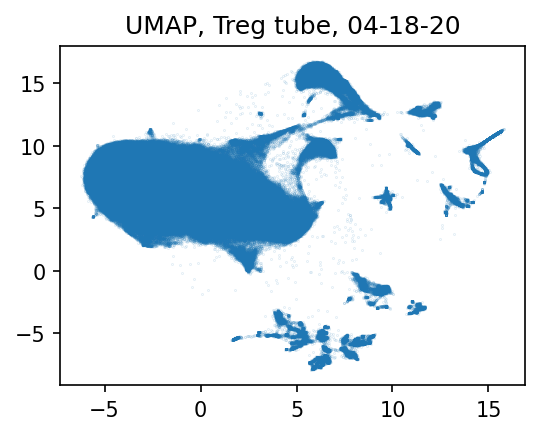

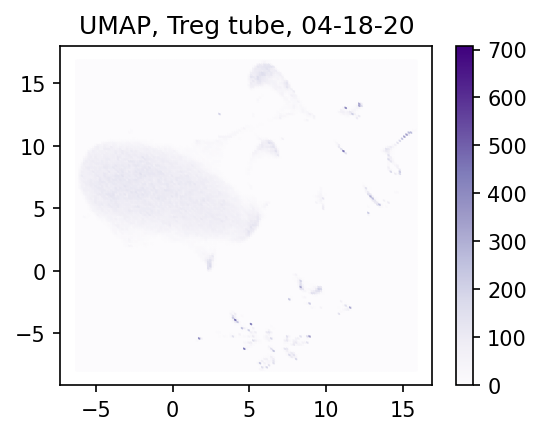

CPU times: user 9min 38s, sys: 1.98 s, total: 9min 40s
Wall time: 1min 16s


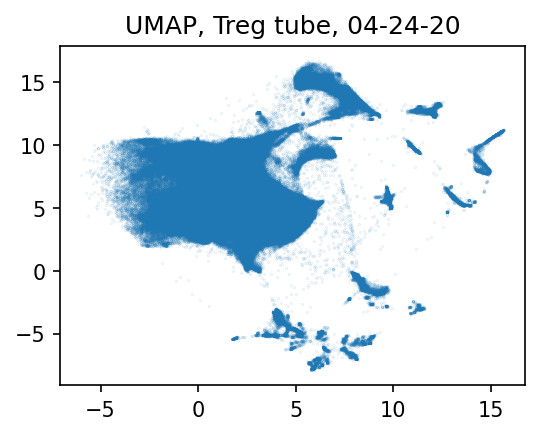

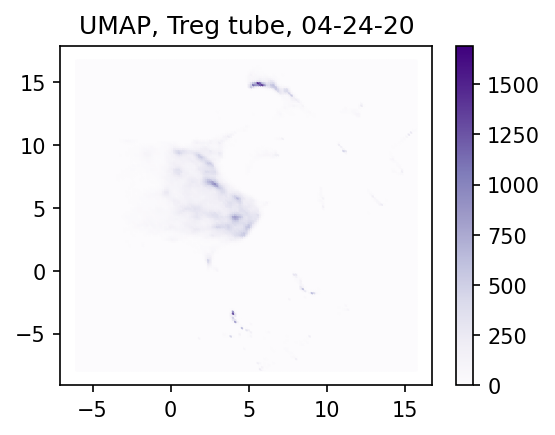

CPU times: user 15min 16s, sys: 2.4 s, total: 15min 18s
Wall time: 2min 5s


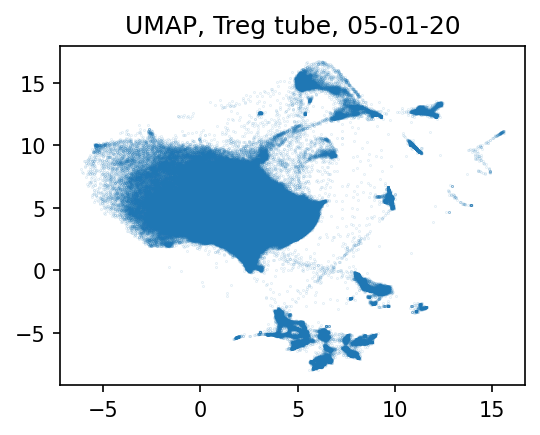

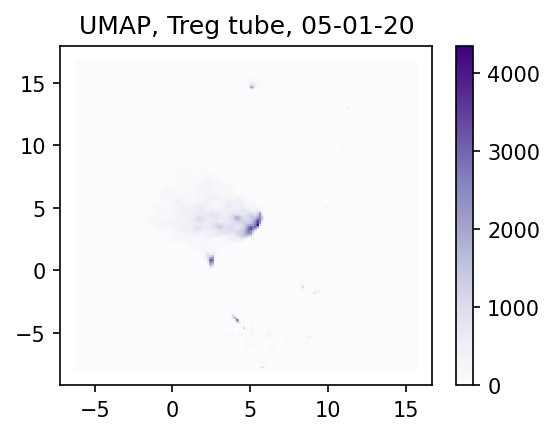

CPU times: user 6min 15s, sys: 1.17 s, total: 6min 16s
Wall time: 49.6 s


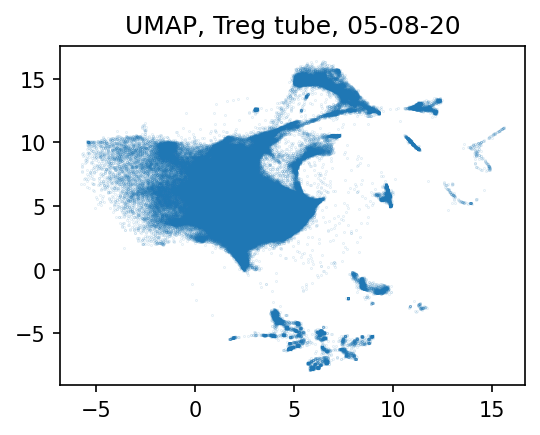

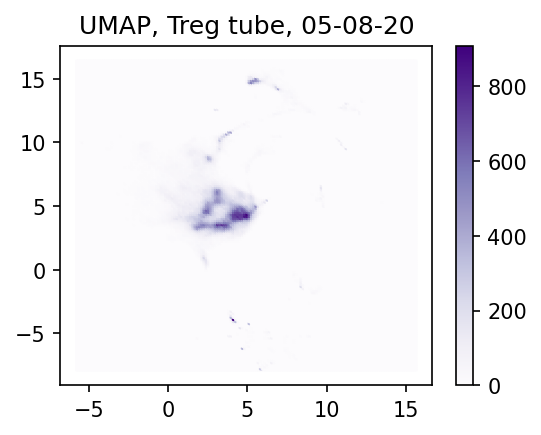

CPU times: user 7min 54s, sys: 1.25 s, total: 7min 55s
Wall time: 1min 5s


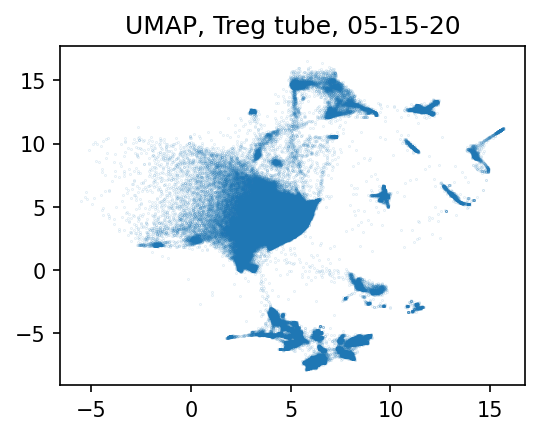

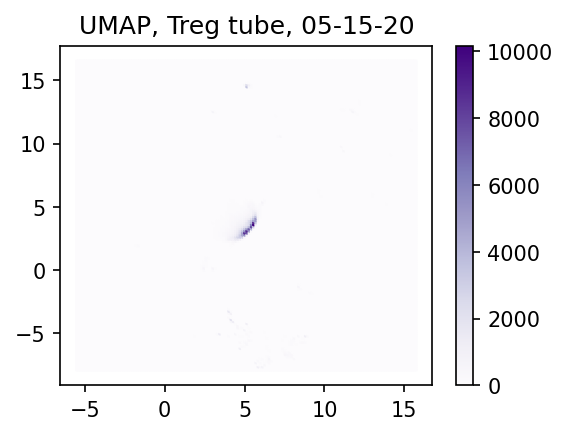

CPU times: user 6min 23s, sys: 1.08 s, total: 6min 24s
Wall time: 53.1 s


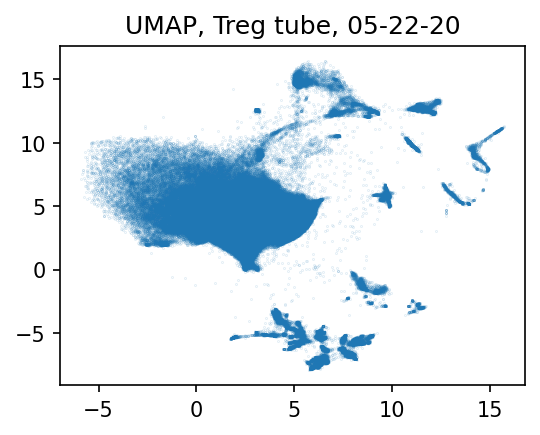

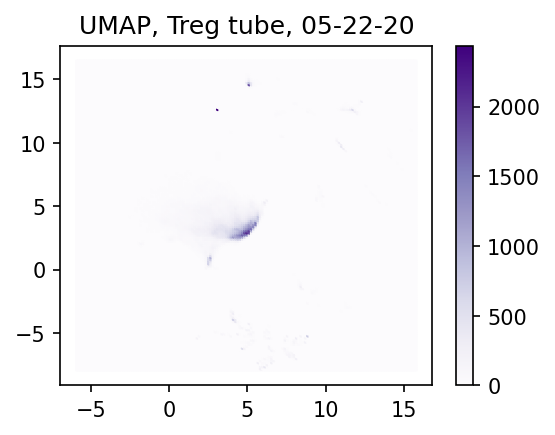

CPU times: user 7min 8s, sys: 1.35 s, total: 7min 9s
Wall time: 1min


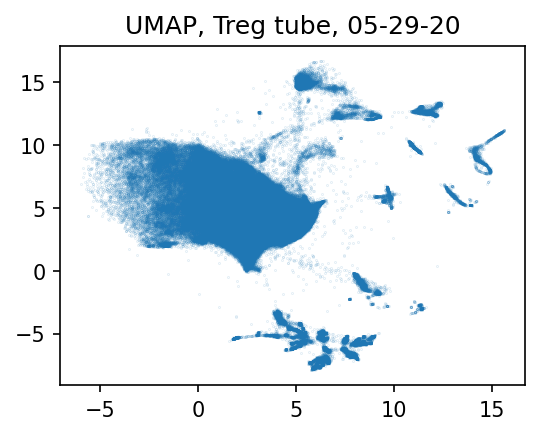

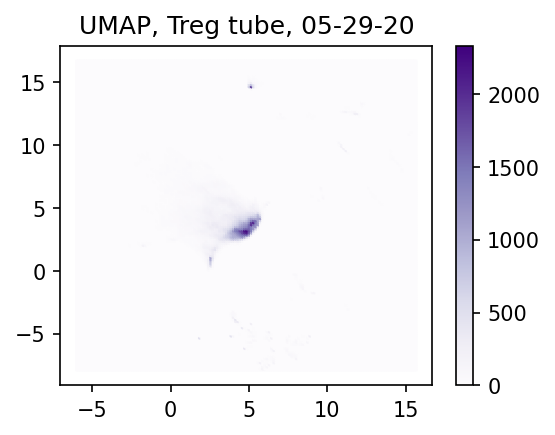

In [15]:
for i, path in enumerate(patient_Treg_samples['File_Path'].to_list()):
    meta, data = fcsparser.parse(path, reformat_meta=True)
    del data['Time']
    del data['FSC-H']
    del data['SSC-H']
    data = transform_FCS_data(data.values)
    %time u = fit.transform(data)
    
    #Make a scatter plot.
    figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
    plt.scatter(u[:,0], u[:,1], s=0.01, alpha=0.5)
    plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[i])
    plt.show()
    
    #Plot it as a hexbin heatmap.
    figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
    plt.hexbin(u[:,0], u[:,1], gridsize=(150,150), cmap=plt.cm.Purples)
    plt.colorbar()
    plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[i])
    plt.show()



CPU times: user 6min 38s, sys: 1.23 s, total: 6min 39s
Wall time: 1min 2s
UMAP, Treg tube, 04-18-20


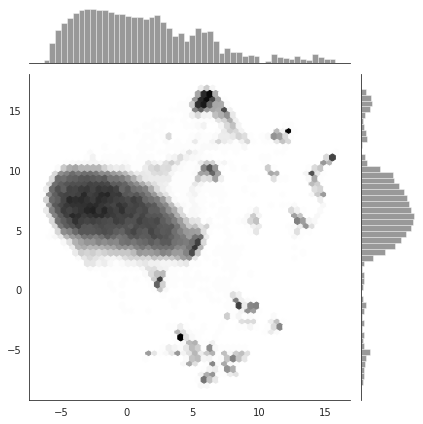

CPU times: user 9min 36s, sys: 2.56 s, total: 9min 38s
Wall time: 1min 15s
UMAP, Treg tube, 04-24-20


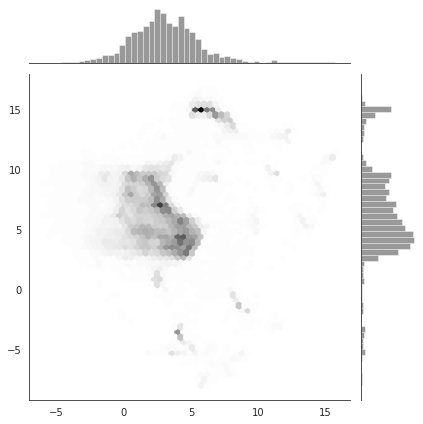

CPU times: user 15min 20s, sys: 3.14 s, total: 15min 23s
Wall time: 2min 6s
UMAP, Treg tube, 05-01-20


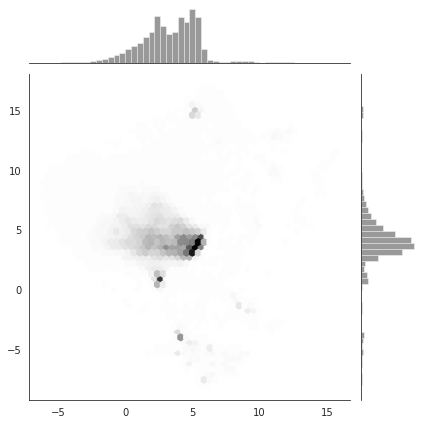

CPU times: user 6min 14s, sys: 1.22 s, total: 6min 15s
Wall time: 49.5 s
UMAP, Treg tube, 05-08-20


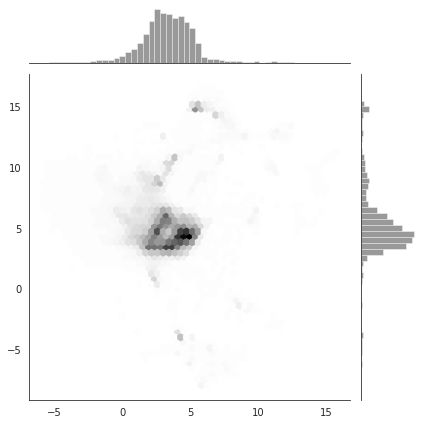

CPU times: user 7min 52s, sys: 1.25 s, total: 7min 53s
Wall time: 1min 5s
UMAP, Treg tube, 05-15-20


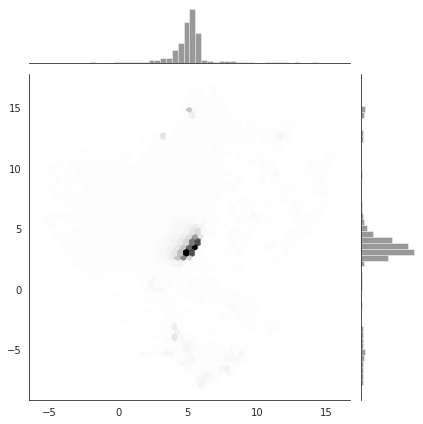

CPU times: user 6min 27s, sys: 1.09 s, total: 6min 28s
Wall time: 53.3 s
UMAP, Treg tube, 05-22-20


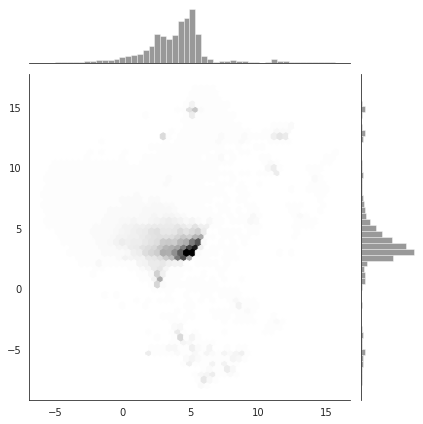

CPU times: user 7min 11s, sys: 1.25 s, total: 7min 13s
Wall time: 59.3 s
UMAP, Treg tube, 05-29-20


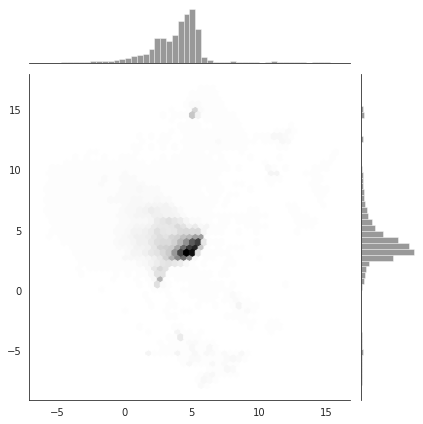

In [16]:
#Just plot the hexbins
for i, path in enumerate(patient_Treg_samples['File_Path'].to_list()):
    meta, data = fcsparser.parse(path, reformat_meta=True)
    del data['Time']
    del data['FSC-H']
    del data['SSC-H']
    data = transform_FCS_data(data.values)
    %time u = fit.transform(data)
    
    print('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[i])
    with sns.axes_style("white"):
        sns.jointplot(u[:,0], u[:,1], kind="hex", color="k", bins=100);
    plt.show()
    

CPU times: user 6min 42s, sys: 1.16 s, total: 6min 43s
Wall time: 1min 1s


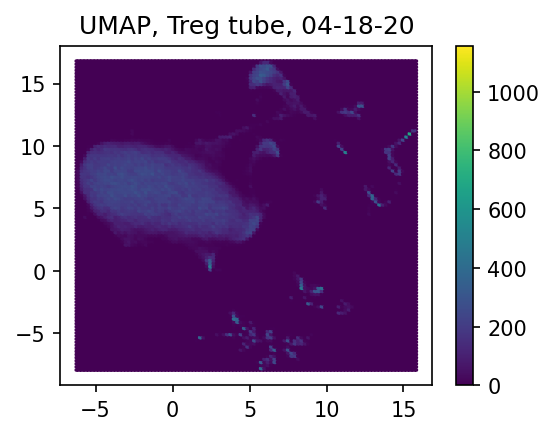

CPU times: user 9min 41s, sys: 1.97 s, total: 9min 43s
Wall time: 1min 15s


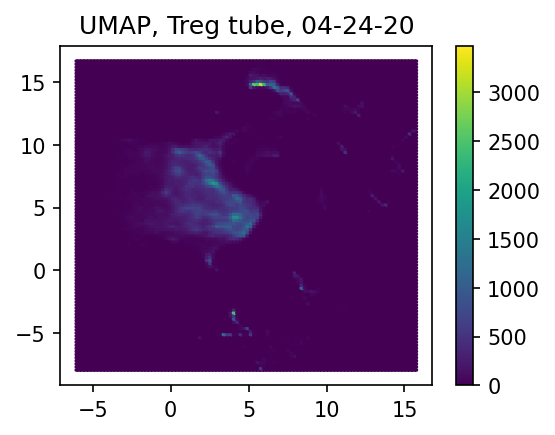

CPU times: user 15min 28s, sys: 3.21 s, total: 15min 31s
Wall time: 2min 6s


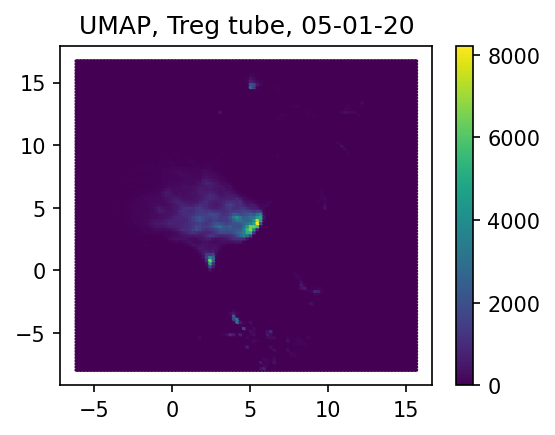

CPU times: user 6min 19s, sys: 1.21 s, total: 6min 20s
Wall time: 48.9 s


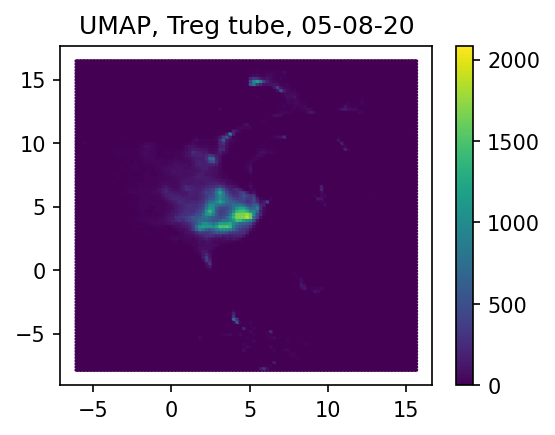

CPU times: user 7min 59s, sys: 1.57 s, total: 8min
Wall time: 1min 4s


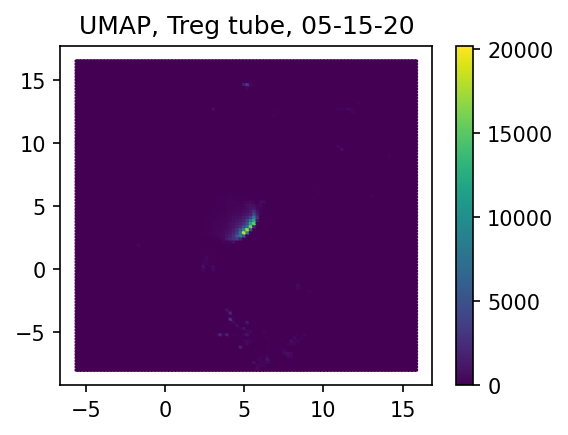

CPU times: user 6min 26s, sys: 1.25 s, total: 6min 27s
Wall time: 52.7 s


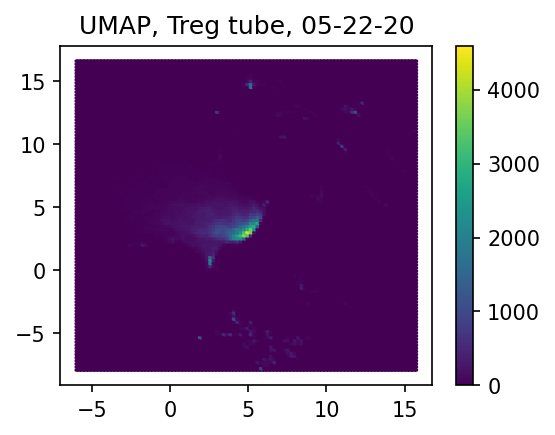

CPU times: user 7min 11s, sys: 1.29 s, total: 7min 12s
Wall time: 59.8 s


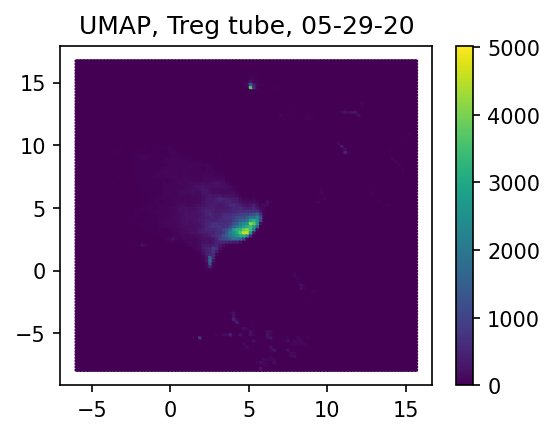

In [17]:
for i, path in enumerate(patient_Treg_samples['File_Path'].to_list()):
    meta, data = fcsparser.parse(path, reformat_meta=True)
    del data['Time']
    del data['FSC-H']
    del data['SSC-H']
    data = transform_FCS_data(data.values)
    %time u = fit.transform(data)
    

    #Plot it as a hexbin heatmap.
    figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
    plt.hexbin(u[:,0], u[:,1], gridsize=(100,100))
    plt.colorbar()
    plt.title('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[i])
    plt.show()



In [18]:
#Okay, now I am going to make the embedding using all points in the data.  
#Then, I will transform the other files and plot.

#Approach 2: make embedding using some cells from each sample.


data_list = []
for path in patient_Treg_samples['File_Path'].to_list():
    meta, data = fcsparser.parse(path, reformat_meta=True)
    del data['Time']
    del data['FSC-H']
    del data['SSC-H']
    print(data.shape)
    data = transform_FCS_data(data.values[0:50000,:])
    data_list.append(data)
    
data_concatenated = np.concatenate(data_list, axis=0)
print(data_concatenated.shape)


(567657, 12)
(863289, 12)
(1435478, 12)
(564239, 12)
(757289, 12)
(574770, 12)
(669531, 12)
(350000, 12)


CPU times: user 39min 3s, sys: 32.8 s, total: 39min 36s
Wall time: 4min 18s


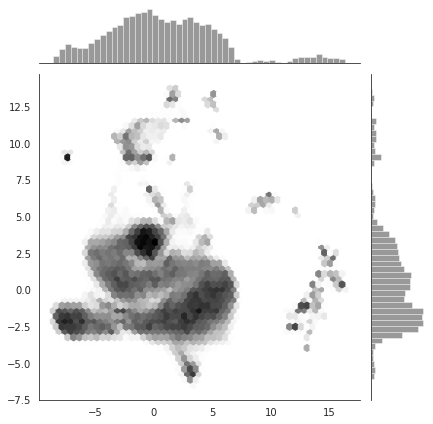

In [19]:
fit = umap.UMAP()
%time u = fit.fit_transform(data_concatenated)

#umap.plot.points(u)
#plt.show()

#%time u = fit.transform(data)

#
with sns.axes_style("white"):
    sns.jointplot(u[:,0], u[:,1], kind="hex", color="k", bins=100);
  

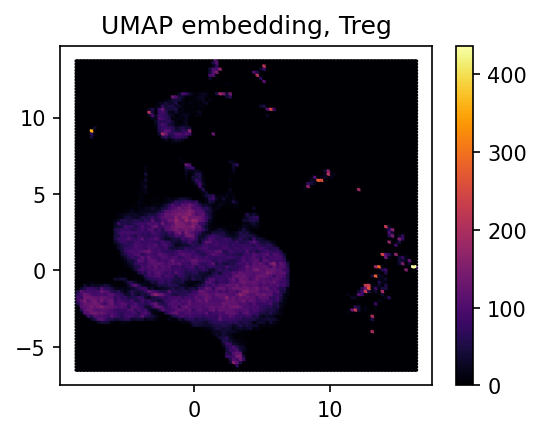

In [20]:
#Plot it as a hexbin heatmap.
figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
plt.hexbin(u[:,0], u[:,1], gridsize=(100,100), cmap='inferno')
plt.colorbar()
plt.title('UMAP embedding, Treg')
plt.show()



CPU times: user 6min 37s, sys: 1.09 s, total: 6min 38s
Wall time: 59.4 s
UMAP, Treg tube, 04-18-20


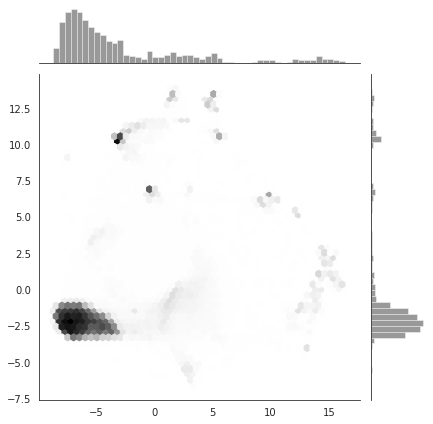

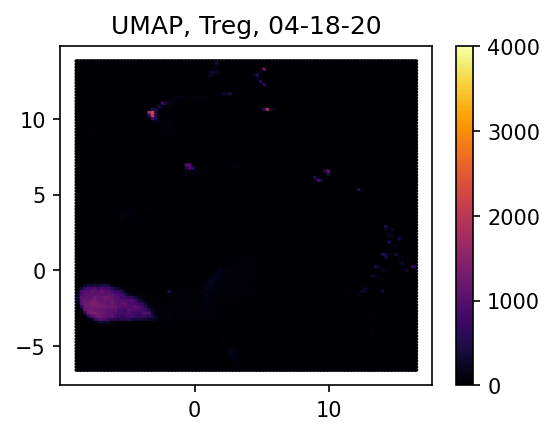

CPU times: user 13min 8s, sys: 1.43 s, total: 13min 10s
Wall time: 1min 38s
UMAP, Treg tube, 04-24-20


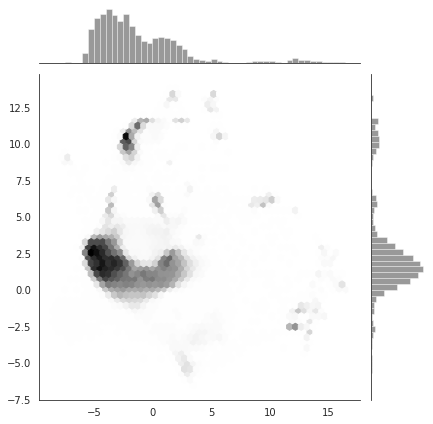

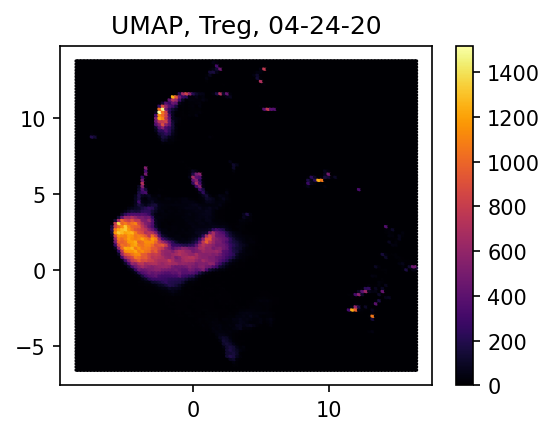

CPU times: user 17min 1s, sys: 3.27 s, total: 17min 4s
Wall time: 2min 42s
UMAP, Treg tube, 05-01-20


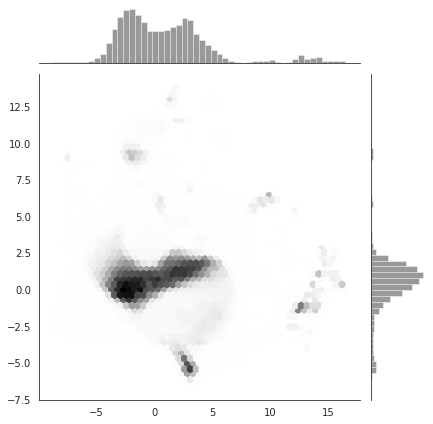

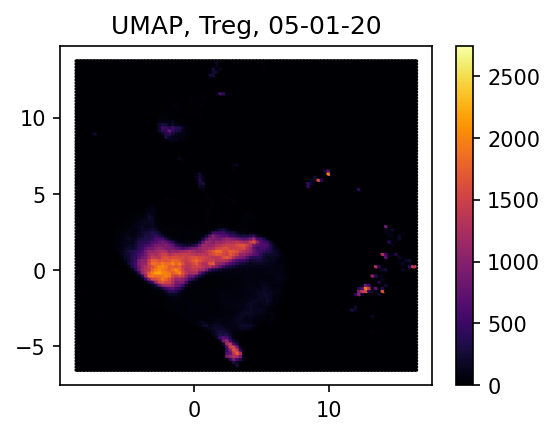

CPU times: user 6min 8s, sys: 856 ms, total: 6min 9s
Wall time: 56.6 s
UMAP, Treg tube, 05-08-20


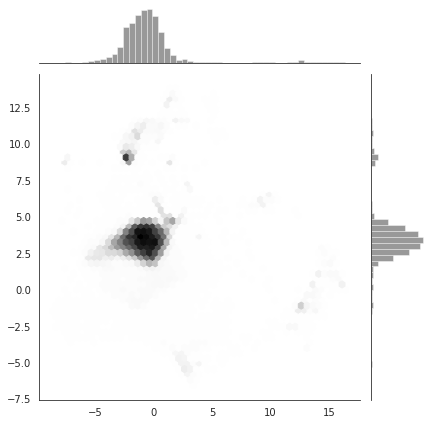

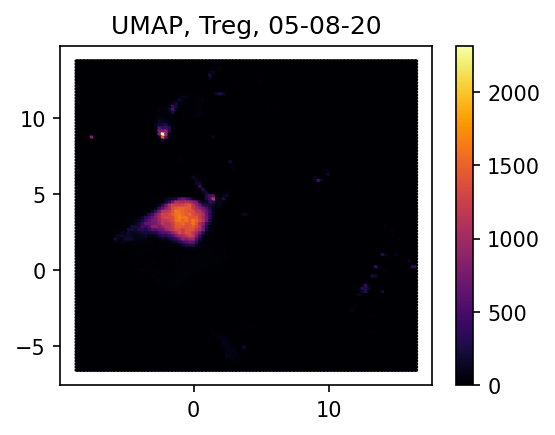

CPU times: user 11min 53s, sys: 1.46 s, total: 11min 54s
Wall time: 1min 29s
UMAP, Treg tube, 05-15-20


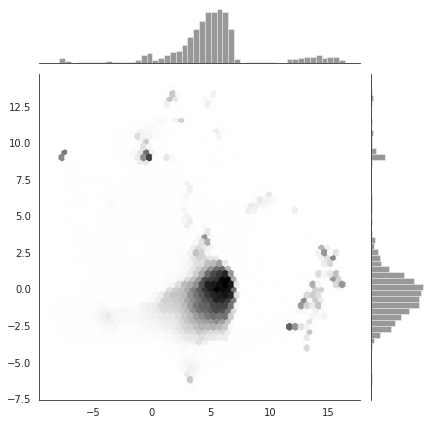

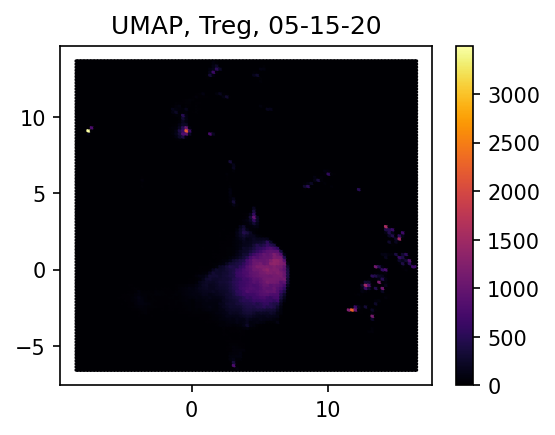

CPU times: user 6min 41s, sys: 1.02 s, total: 6min 42s
Wall time: 1min 6s
UMAP, Treg tube, 05-22-20


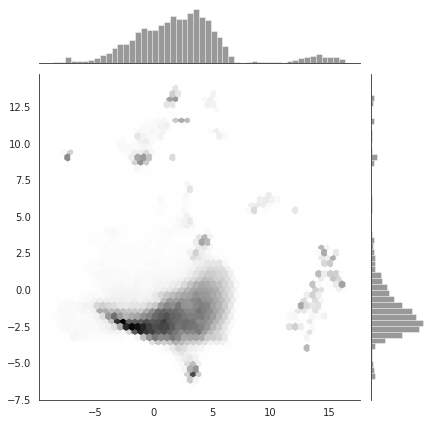

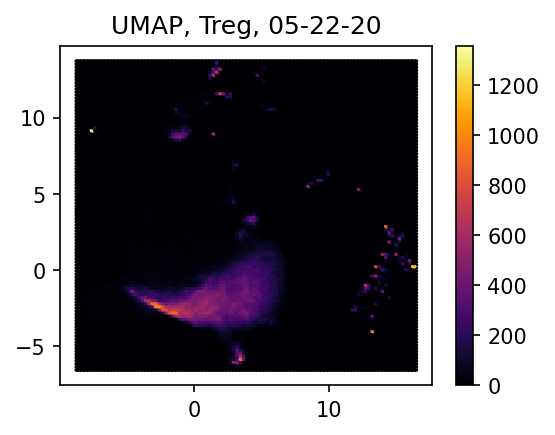

CPU times: user 10min 21s, sys: 1.17 s, total: 10min 22s
Wall time: 1min 19s
UMAP, Treg tube, 05-29-20


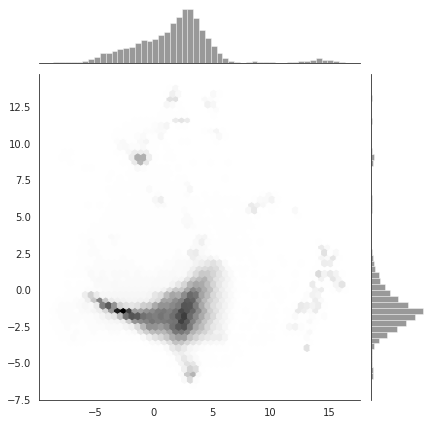

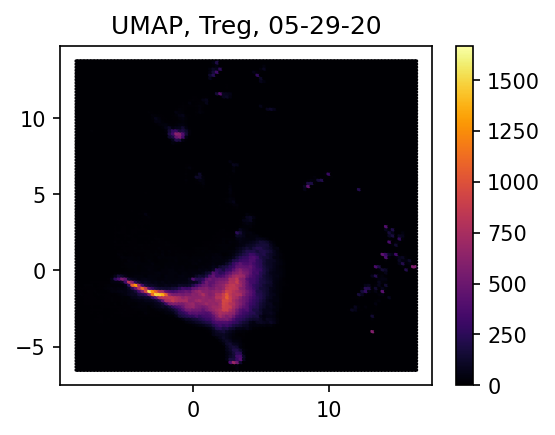

In [21]:
#Just plot the hexbins
for i, path in enumerate(patient_Treg_samples['File_Path'].to_list()):
    meta, data = fcsparser.parse(path, reformat_meta=True)
    del data['Time']
    del data['FSC-H']
    del data['SSC-H']
    data = transform_FCS_data(data.values)
    %time u = fit.transform(data)
    
    print('UMAP, Treg tube, ' + patient_Treg_samples['Date'].to_list()[i])
    with sns.axes_style("white"):
        sns.jointplot(u[:,0], u[:,1], kind="hex", color="k", bins=150);
    plt.show()
    
    figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
    plt.hexbin(u[:,0], u[:,1], gridsize=(100,100), cmap='inferno')
    plt.colorbar()
    plt.title('UMAP, Treg, ' + patient_Treg_samples['Date'].to_list()[i])
    plt.show()

In [22]:
#Data for plotly

path = patient_Treg_samples['File_Path'].to_list()[0]
meta, data = fcsparser.parse(path, reformat_meta=True)
del data['Time']
del data['FSC-H']
del data['SSC-H']
column_names = data.columns
data = transform_FCS_data(data.values)
%time u = fit.transform(data)
    
original_df = pd.DataFrame(data)
original_df.columns = column_names
print(type(original_df))
original_df['umap_x']  = u[:, 0]
original_df['umap_y']  = u[:, 1]
df=original_df.copy()

layout = dict(width=600, 
              height=600, 
              #autosize=False,
              xaxis=dict(zeroline=False),
              hovermode='closest',
              coloraxis_showscale=True
             )

marker = dict(colorscale='Viridis',
              #color=df[fcs_file.better_channel_names[0]],
              #colorbar=dict(thickness=5),
              size = 0.5, opacity = 0.5)

CPU times: user 6min 38s, sys: 891 ms, total: 6min 39s
Wall time: 1min
<class 'pandas.core.frame.DataFrame'>


In [23]:
base_auto_file_name = "base_name.csv"

accession_number = "paul1"

In [26]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import numpy as np
from ipywidgets import interactive, HBox, VBox
from ipywidgets import widgets

import plotly.io as pio
import plotly.express as px

#Plotly default settings, etc.
pio.templates.default = "simple_white"

py.init_notebook_mode()

#Widgets

#Figure widgets
figure_size = 400
num_selected = 0

f = go.FigureWidget([go.Scattergl(y = df['umap_y'], 
                                  x = df['umap_x'], 
                                  mode = 'markers' ,
                                  marker=marker, 
                                  hoverinfo='none',
                                  selected={'marker':{'color':'red', 'opacity':1.0}}
                                 )])

f.layout.yaxis = dict(scaleanchor = "x", scaleratio = 1,)
f.update_layout(
    autosize=False,
    width=figure_size,
    height=figure_size,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

f.layout.xaxis.title = 'umap_x'
f.layout.yaxis.title = 'umap_y'
scatter = f.data[0]

f2 = go.FigureWidget([go.Scattergl(y = df['umap_y'], 
                                   x = df['umap_x'], 
                                   mode = 'markers', marker=marker,
                                   hoverinfo='none',
                                   selected={'marker':{'color':'red', 'opacity':1.0}})]
                    )
f2.update_layout(
    autosize=False,
    width=figure_size,
    height=figure_size,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
f2.update_layout(coloraxis_showscale=True)

f2.layout.yaxis = dict(scaleanchor = "x", scaleratio = 1,)
f2.layout.xaxis.title = 'umap_x'
f2.layout.yaxis.title = 'umap_y'
scatter2 = f2.data[0]

def update_num_selected_points():
    if f.data[0].selectedpoints == 'None':
        num_selected = 0
    else:
        num_selected = len(f.data[0].selectedpoints)
    print("Updated number of selected points to ", num_selected)

def selection_fn(trace,points,selector):
    f2.data[0].update(selectedpoints=points.point_inds)
    update_num_selected_points()
def selection_fn2(trace,points,selector):
    f.data[0].update(selectedpoints=points.point_inds)
    update_num_selected_points()
    
scatter.on_selection(selection_fn)
scatter2.on_selection(selection_fn2)

def update_axes(c):
    scatter = f.data[0]
    xaxis = xaxis_dropdown.value
    yaxis = yaxis_dropdown.value
    #scatter.x = df[xaxis]
    #scatter.y = df[yaxis]
    with f.batch_update():
        f.data[0].x = df[xaxis]
        f.data[0].y = df[yaxis]
        f.layout.xaxis.title = xaxis
        f.layout.yaxis.title = yaxis
        
xaxis_dropdown = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='x axis:',
    disabled=False,
)
xaxis_dropdown.observe(update_axes)

yaxis_dropdown = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='y axis:',
    disabled=False,
)
yaxis_dropdown.observe(update_axes)

def update_axes2(c):
    scatter = f2.data[0]
    xaxis = xaxis_dropdown2.value
    yaxis = yaxis_dropdown2.value
    #scatter.x = df[xaxis]
    #scatter.y = df[yaxis]
    with f2.batch_update():
        f2.data[0].x = df[xaxis]
        f2.data[0].y = df[yaxis]
        f2.layout.xaxis.title = xaxis
        f2.layout.yaxis.title = yaxis
        
xaxis_dropdown2 = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='x axis:',
    disabled=False,
)
xaxis_dropdown2.observe(update_axes2)

yaxis_dropdown2 = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='y axis:',
    disabled=False,
)
yaxis_dropdown2.observe(update_axes2)


def convert_df_indices_to_original_indices():
    #indices = list(f.data[0].selectedpoints)
    temp = pd.DataFrame(list(df.index.values))
    orig_indices = temp[0]
    #print(orig_indices)
    return orig_indices

def update_color_labels(c):
    color_labels = original_df[color_dropdown.value].loc[convert_df_indices_to_original_indices()]
    scatter = f.data[0]
    scatter.marker.color=color_labels
    #print("still to do...")
color_dropdown = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='color by',
    disabled=False,
)
color_dropdown.observe(update_color_labels)

def update_color_labels2(c):
    color_labels = original_df[color_dropdown2.value].loc[convert_df_indices_to_original_indices()]
    scatter = f2.data[0]
    scatter.marker.color=color_labels
    #print("still to do...")
color_dropdown2 = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='color by',
    disabled=False,
)
color_dropdown2.observe(update_color_labels2)



#More widgets
textbox = widgets.Text(
    description='Save as:   ',
    value='./output/fcs_annotations/selected_cells.csv',
)


#print(f.data[0].selectedpoints)
num_selected_cells = widgets.Text(
    description='Number selected:   ',
    value=str(num_selected),
    disabled=True, continuous_update=True
)

def update_graphs_with_df():
    #Update the data in the graphs.
    scatter = f.data[0]
    scatter.x = df[xaxis_dropdown.value]
    scatter.y = df[yaxis_dropdown.value]
    update_color_labels(0)

    scatter2 = f2.data[0]
    scatter2.x = df[xaxis_dropdown2.value]
    scatter2.y = df[yaxis_dropdown2.value]
    #update_color_labels2(0)

gate_button = widgets.Button(
    description='Gate!',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to reduce the data set to the selected cells.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def gate_data(b):
    global df
    num_selected = len(list(f.data[0].selectedpoints))
    if num_selected > 0:
        indices = list(f.data[0].selectedpoints)
        temp = pd.DataFrame(list(df.index.values))
        orig_indices = temp.loc[indices]
        temp_df = original_df.loc[orig_indices[0]]
        df = temp_df.copy()
        f.data[0].selectedpoints = []
        f2.data[0].selectedpoints = []
        print('Gated!')
        update_graphs_with_df()
    else:
        print("Nothing selected to gate on.")
gate_button.on_click(gate_data)


gate_button = widgets.Button(
    description='Gate!',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to reduce the data set to the selected cells.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def gate_data(b):
    global df
    num_selected = len(list(f.data[0].selectedpoints))
    if num_selected > 0:
        indices = list(f.data[0].selectedpoints)
        temp = pd.DataFrame(list(df.index.values))
        orig_indices = temp.loc[indices]
        temp_df = original_df.loc[orig_indices[0]]
        df = temp_df.copy()
        f.data[0].selectedpoints = []
        f2.data[0].selectedpoints = []
        print('Gated!')
        update_graphs_with_df()
    else:
        print("Nothing selected to gate on.")
gate_button.on_click(gate_data)

remove_cells_button = widgets.Button(
    description='Remove!',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to remove the selected cells.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def remove_data(b):
    global df
    num_selected = len(list(f.data[0].unselected))
    if num_selected > 0:
        indices = list(f.data[0].unselected)
        print(indices)
        #We have to convert the selected/unselected back to the numbering for the original dataframe.
        temp = pd.DataFrame(list(df.index.values))
        orig_indices = temp.loc[indices]
        temp_df = original_df.loc[orig_indices[0]]
        df = temp_df.copy()
        f.data[0].selectedpoints = []
        f2.data[0].selectedpoints = []
        print('Removed cells!')
        update_graphs_with_df()
    else:
        print("Nothing that is not selected.")
remove_cells_button.on_click(remove_data)


reset_gate_button = widgets.Button(
    description='Reset gate',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to undo gating.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def reset_gate(b):
    global df
    df = original_df.copy()
    f.data[0].selectedpoints = []
    f2.data[0].selectedpoints = []
    update_graphs_with_df()
    print('Reset gate!')
reset_gate_button.on_click(reset_gate)

#Common save functions.

def save_as_fcs_file(file_path, the_df):
    #print(the_df.columns)
    fcswrite.write_fcs(filename=file_path,
           chn_names=list(the_df.columns),
           data=the_df.values)
    #original_indices = the_df.indices
    #original_indices.to_csv(file_path + '_indices.txt')
    
def save_indices(file_path, indices):
    #with open(file_path, 'w') as filehandle:
    #    for listitem in indices:
    #        filehandle.write('%s\n' % listitem)
    data = np.array(indices)
    np.save(file_path + '.npy', data)
    #print(np.load(file_path + '.npy'))
    
def save_selected(file_path):
    indices = list(f.data[0].selectedpoints)
    temp = pd.DataFrame(list(df.index.values))
    orig_indices = temp.loc[indices]
    original_df.loc[orig_indices[0]].to_csv(file_path, index=False)
    print('Saved file as ' + file_path)
    save_these_indices = list(temp.loc[indices][0])
    save_indices(file_path[0:-4] + '_indices.csv', save_these_indices)
    if len(save_these_indices) > 0:
        save_as_fcs_file(file_path[0:-4] + '.fcs', original_df.loc[orig_indices[0]])

def save_complement_of_selected(file_path):
    indices = set(f.data[0].selectedpoints)
    temp = pd.DataFrame(list(df.index.values))
    orig_indices = set(temp.loc[indices][0])
    
    all_indices = set(original_df.index)
    difference = list(all_indices - orig_indices)
    original_df.loc[difference].to_csv(file_path, index=False)
    print('Saved complement file as ' + file_path)
    save_indices(file_path[0:-4] + '_indices.csv', difference)
    if(len(difference)> 0):
        save_as_fcs_file(file_path[0:-4] + '.fcs', original_df.loc[difference])


#Buttons instantiation.
save_button = widgets.Button(
    description='Save selected',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to save the selected data in the file in the \'Save as\' box.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def save_file(b):
    save_selected(textbox.value)
    print("Saved selected.")
save_button.on_click(save_file)

save_complement_button = widgets.Button(
    description='Save complement of selected',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to save the complement of the selected data in the file in the \'Save as\' box.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def save_complement(b):
    save_complement_of_selected(textbox.value)
    print("Saved complement.")
save_complement_button.on_click(save_complement)

save_junk_button = widgets.Button(
    description='Save non-WBCs',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to save selected non-WBCs.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def save_junk(b):
    file_path = './output/fcs_annotations/non-WBCs_' + base_auto_file_name
    save_selected(file_path)
    file_path = './output/fcs_annotations/WBCs_' + base_auto_file_name
    save_complement_of_selected(file_path)
save_junk_button.on_click(save_junk)


save_WBCs_button = widgets.Button(
    description='Save WBCs',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to save selected WBCs and complement of WBCs.  Output will be two files with names WBCs_.csv and non-WBCs.csv.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def save_WBCs(b):
    file_path = './output/fcs_annotations/WBCs_' + base_auto_file_name
    save_selected(file_path)
    file_path = './output/fcs_annotations/non-WBCs_' + base_auto_file_name
    save_complement_of_selected(file_path)
save_WBCs_button.on_click(save_WBCs)

save_BCells_button = widgets.Button(
    description='Save B cells',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to save selected WBCs and complement of WBCs.  Output will be two files with names WBCs_.csv and non-WBCs.csv.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def save_BCells(b):
    file_path = './output/fcs_annotations/BCells_' + base_auto_file_name
    save_selected(file_path)
    file_path = './output/fcs_annotations/non-BCells_' + base_auto_file_name
    save_complement_of_selected(file_path)
save_BCells_button.on_click(save_BCells)

save_CD5PosBCells_button = widgets.Button(
    description='Save CD5+ B Cells',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to save selected WBCs and complement of WBCs.  Output will be two files with names WBCs_.csv and non-WBCs.csv.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def save_CD5PosBCells(b):
    file_path = './output/fcs_annotations/CD5PosBCells_' + base_auto_file_name
    save_selected(file_path)
    file_path = './output/fcs_annotations/non-CD5PosBCells_' + base_auto_file_name
    save_complement_of_selected(file_path)
save_CD5PosBCells_button.on_click(save_CD5PosBCells)

load_next_button = widgets.Button(
    description='Load next',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to load the next case in the list.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def load_next_case(b):
    print("still to do...")
load_next_button.on_click(load_next_case)

load_prior_button = widgets.Button(
    description='Load prior',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to load the next case in the list.',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def load_prior_case(b):
    print("still to do...")
load_prior_button.on_click(load_prior_case)

loaded_case = widgets.Text(
    description='Loaded case:   ',
    value=accession_number,
    disabled=True
)

#Widget containers (for visual orgazation)
widget_save_container = widgets.HBox([textbox, save_button, save_complement_button])
specifics_save_container = widgets.HBox([save_junk_button, save_WBCs_button, save_BCells_button, save_CD5PosBCells_button])
#specifics_save_container = widgets.HBox([save_WBCs_button, save_BCells_button, save_CD5PosBCells_button])

#fig1_container = VBox([xaxis_dropdown, yaxis_dropdown, color_dropdown, f])
#fig2_container = VBox([xaxis_dropdown2, yaxis_dropdown2, color_dropdown2, f2])
fig1_container = VBox([xaxis_dropdown, yaxis_dropdown, f])
fig2_container = VBox([xaxis_dropdown2, yaxis_dropdown2, f2])



In [28]:
#Display widgets.
VBox(
    (HBox([loaded_case]),
      HBox([fig1_container, fig2_container]),
      #widgets.HBox([gate_button, reset_gate_button, num_selected_cells]),
      widgets.HBox([gate_button, remove_cells_button, reset_gate_button]),
      specifics_save_container,
      widget_save_container
      ))

print("Done.")

Done.
